### laba 1

### Задача клас
сификации. Данные в датасете хранятся из отчетов МЧС <p> Основной датасет будет доступен архивом под названием wildfires-data-train.zip по ссылке: <br>&diams;<em> https://drive.google.com/file/d/1xCGBWdT_Xxp-TtWWExA_wf4nnPjhrigU/view?usp=sharing</em></p>

Необходимо по информации о точке температурной аномалии, классифицировать тип пожара (по классификации МЧС).
<br>Основной датасет называется "wildfires_train.csv". В нем находятся следующие признаки:
<br>1) date - дата проявления одного из типов пожара
<br>2) fire_type - тип пожара значения от 1 до 11 (наш целевой признак)
<br>3) fire_type_name - описания события пожар (возможно, можно опознать выбросы по этому признаку)
<br>4) latitude - широта (координаты возможного возгорания)
<br>5) longitude - долгота (координаты возможного возгорания)
<br>6) temperature - температура в точке в определенный момент времени
<br>7) t1w - показатель температуры за 1 неделю до момента регистрации точки
<br>8) t2w - показатель температуры за 2 недели до момента регистрации точки
<br>9) t3w - показатель температуры за 3 недели до момента регистрации точки
<br>10) humidity - относительная влажность в определенной точке
<br>11) h1w - показатель влажности за 1 неделю до момента регистрации точки
<br>12) h2w - показатель влажности за 2 недели до момента регистрации точки
<br>13) h3w - показатель влажности за 3 недели до момента регистрации точки
<br>14) uwind - показатель компонент воздуха в точке

In [1]:
import numpy as np
import pandas as pd
import xarray
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import requests
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample
from sklearn.svm import SVC

%matplotlib inline


/home/topus/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/topus/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## NCEP Dataset
Известный датасет, который хранит в себе погодный данные из проекта NCEP Reanalysis 2 - усредненные за день данные по <b>температуре воздуха, отнсительная влажность и компоненты воздуха с 1979 года. </b>
<br>Нам потребуются данные начиная с 2012 года. В ссылках меняем год каждый раз до 2019</br>
<br>Требуется загрузить набор данных в каталог <em>data/ncep</em>:</br>
<br>&diams; https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2012.nc</br>
<br>&diams; https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2012.nc</br>
<br>&diams; https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2012.nc</br>

#### К сожалению данные у меня будут только за период 2018-2019 из-за этого выборка из 170 000 наблюдений сократится до ~ 22 000 наблюдений из-за чего результат ухудшится. 
<p>Просто если я загружаю погодные данные за период 2012-2019 то не хватает оперативной памяти чтобы смержить все эти данные вместе. Пробовал в colab, также не хватило 12gb оперативки. Возможно это из-за того, как я решил временно хранить данные о погодных условиях. <br>Буду рад обсудить данный момент в день экзамена</p>

In [2]:
ncep_data = []
year = 2018
for var in ('air', 'uwnd', 'rhum'):
    dataset_filename = '/home/topus/Desktop/Ml_tasks_Zolotykh/{}.{}.nc'.format(var, year)
    ncep_data.append(xarray.open_dataset(dataset_filename))
ncep_data = xarray.merge(ncep_data)

/home/topus/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/topus/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'uwnd' has multiple fill values {-99, 32767}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/topus/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'rhum' has multiple fill values {-99, 32767}, decoding all values to NaN.
  use_cftime=use_cftime,


## Набор признаков на основе данных NCEP Reamalysis 2
<br>Ищем наиболее близкий к точке узел сетки в наборе NCEP, в качестве признаков значения переменных зарегистрированные в день регистрации точки и агрегированные показатели за период от 1 до 3х недель до момента регистрации точки. Точка определяется исходя из координат долгота и широта

In [3]:
def extract_features(row):
    point = ncep_data.sel(
        lon=row['longitude'],
        lat=row['latitude'],
        level=1000,
        method='nearest',
    )

    p1w = point.rolling(time=7).mean()
    p2w = point.rolling(time=14).mean()
    p3w = point.rolling(time=21).mean()
    
    date = row['date']
    v = point.sel(time=date)
    v1w = p1w.sel(time=date)
    v2w = p2w.sel(time=date)
    v3w = p3w.sel(time=date)
    
    return {
        'fire_type': row['fire_type'],
        'fire_type_name': row['fire_type_name'],
        'date': row['date'], 
        'temperature': v.air.values.item(0),
        'humidity': v.rhum.values.item(0),
        'uwind': v.uwnd.values.item(0),
        't1w': v1w.air.values.item(0),
        't2w': v2w.air.values.item(0),
        't3w': v3w.air.values.item(0),
        'h1w': v1w.rhum.values.item(0),
        'h2w': v2w.rhum.values.item(0),
        'h3w': v3w.rhum.values.item(0)
    }

Получаем наш конечный датасет, который позже разделим на тренировочную и тестовую выборки

In [4]:
df_train = pd.read_csv('/home/topus/zolotyh/data/wildfires_train.csv')
df_subsample = df_train.query('(date >= "2018") & (date <= "2019")')

df_features = []
for i, row in tqdm(df_subsample.iterrows(), total=df_subsample.shape[0]):
    features = extract_features(row)
    df_features.append(features)

df_features = pd.DataFrame(df_features)

In [5]:
df_features.head(5)

,date,fire_type,fire_type_name,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
0,2018-01-01,3,горение мусора,NaN,NaN,NaN,87.479996,NaN,NaN,NaN,253.160004,0.229996
1,2018-01-01,9,природный пожар,NaN,NaN,NaN,94.029999,NaN,NaN,NaN,253.479996,-0.809998
2,2018-01-01,3,горение мусора,NaN,NaN,NaN,99.130005,NaN,NaN,NaN,249.009995,1.490005
3,2018-01-01,4,сжигание порубочных остатков,NaN,NaN,NaN,89.630005,NaN,NaN,NaN,255.229996,1.770004
4,2018-01-02,4,сжигание порубочных остатков,NaN,NaN,NaN,92.300003,NaN,NaN,NaN,256.910004,0.690002


In [6]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22820 entries, 0 to 22819
Data columns (total 12 columns):
date              22820 non-null object
fire_type         22820 non-null int64
fire_type_name    22820 non-null object
h1w               22802 non-null float64
h2w               22773 non-null float64
h3w               22737 non-null float64
humidity          22820 non-null float64
t1w               22802 non-null float64
t2w               22773 non-null float64
t3w               22737 non-null float64
temperature       22820 non-null float64
uwind             22820 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 2.1+ MB


In [7]:
df_features.describe()

,fire_type,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
count,22820.000000,22802.000000,22773.000000,22737.000000,22820.000000,22802.000000,22773.000000,22737.000000,22820.000000,22820.000000
mean,8.006836,58.469738,61.559803,63.200055,53.192548,281.677348,280.893567,280.147403,282.568087,0.663076
std,2.435521,13.869626,13.032649,12.790965,16.376868,8.661417,8.627909,8.907320,9.420266,3.342818
min,1.000000,21.301428,24.717136,28.319517,14.329987,235.308563,235.762878,237.569031,234.339996,-16.419998
25%,6.000000,49.008537,52.695728,54.738571,41.250000,276.910034,275.808594,274.875763,277.539978,-0.979996
50%,9.000000,58.526449,61.877918,64.170006,52.339996,281.487152,280.482117,279.543854,282.690002,0.929993
75%,10.000000,68.235748,71.239967,72.820946,64.639999,287.043533,285.830750,285.285217,289.039978,2.729996
max,11.000000,98.707169,97.955711,97.722824,100.000000,304.605774,303.566376,302.515625,306.059998,12.179993


In [8]:
df_features.shape

(22820, 12)

In [9]:
#Проверим на NA's
df_features.isnull().sum()

date               0
fire_type          0
fire_type_name     0
h1w               18
h2w               47
h3w               83
humidity           0
t1w               18
t2w               47
t3w               83
temperature        0
uwind              0
dtype: int64

In [10]:
# Требуется убрать пустые значения или заполнить. 
# Выбираем самый простой путь заполнения медиана.
df_features.median(axis=0)

fire_type        9.000000
h1w             58.526449
h2w             61.877918
h3w             64.170006
humidity        52.339996
t1w            281.487152
t2w            280.482117
t3w            279.543854
temperature    282.690002
uwind            0.929993
dtype: float64

In [11]:
df_features = df_features.fillna(df_features.median(axis = 0), axis = 0)

In [12]:
df_features.count(axis = 0)

date              22820
fire_type         22820
fire_type_name    22820
h1w               22820
h2w               22820
h3w               22820
humidity          22820
t1w               22820
t2w               22820
t3w               22820
temperature       22820
uwind             22820
dtype: int64

In [13]:
# переменная date нам более не понадобится, поэтому выкидываем из датасета.
df_features = df_features.drop(columns=['date'])

In [14]:
df_features.columns

Index(['fire_type', 'fire_type_name', 'h1w', 'h2w', 'h3w', 'humidity', 't1w',
       't2w', 't3w', 'temperature', 'uwind'],
      dtype='object')

In [15]:
df_features.head(5)

,fire_type,fire_type_name,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
0,3,горение мусора,58.526449,61.877918,64.170006,87.479996,281.487152,280.482117,279.543854,253.160004,0.229996
1,9,природный пожар,58.526449,61.877918,64.170006,94.029999,281.487152,280.482117,279.543854,253.479996,-0.809998
2,3,горение мусора,58.526449,61.877918,64.170006,99.130005,281.487152,280.482117,279.543854,249.009995,1.490005
3,4,сжигание порубочных остатков,58.526449,61.877918,64.170006,89.630005,281.487152,280.482117,279.543854,255.229996,1.770004
4,4,сжигание порубочных остатков,58.526449,61.877918,64.170006,92.300003,281.487152,280.482117,279.543854,256.910004,0.690002


In [16]:
df_features['fire_type'].unique()

array([ 3,  9,  4,  5, 11,  2,  1, 10,  6,  8])

In [17]:
df_features.groupby('fire_type').size()

fire_type
1      276
2       76
3      867
4     1588
5      300
6     4744
8     1994
9     5047
10    5212
11    2716
dtype: int64

### К сожалению из-за того не получилось взять все данные, один класс "7" пропал. Так как все данные по типу пожара "7" были до 2018 года
<p> Также из предыдущих вычислений мы видим, что классы несбалансированны</p>

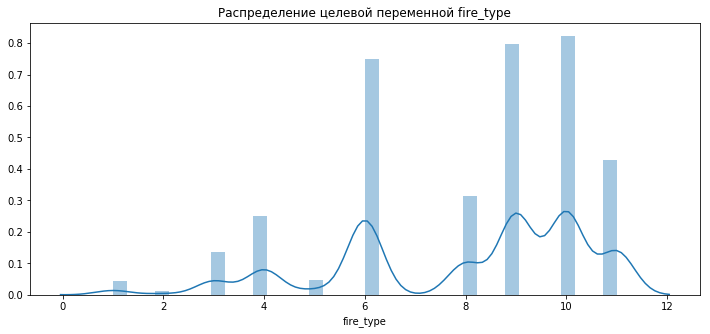

In [18]:
plt.figure(figsize=(12,5))
plt.title("Распределение целевой переменной fire_type")
ax = sns.distplot(df_features["fire_type"])

In [19]:
df_features_new = df_features.copy()
df_features_new = df_features_new.drop(columns='fire_type_name')

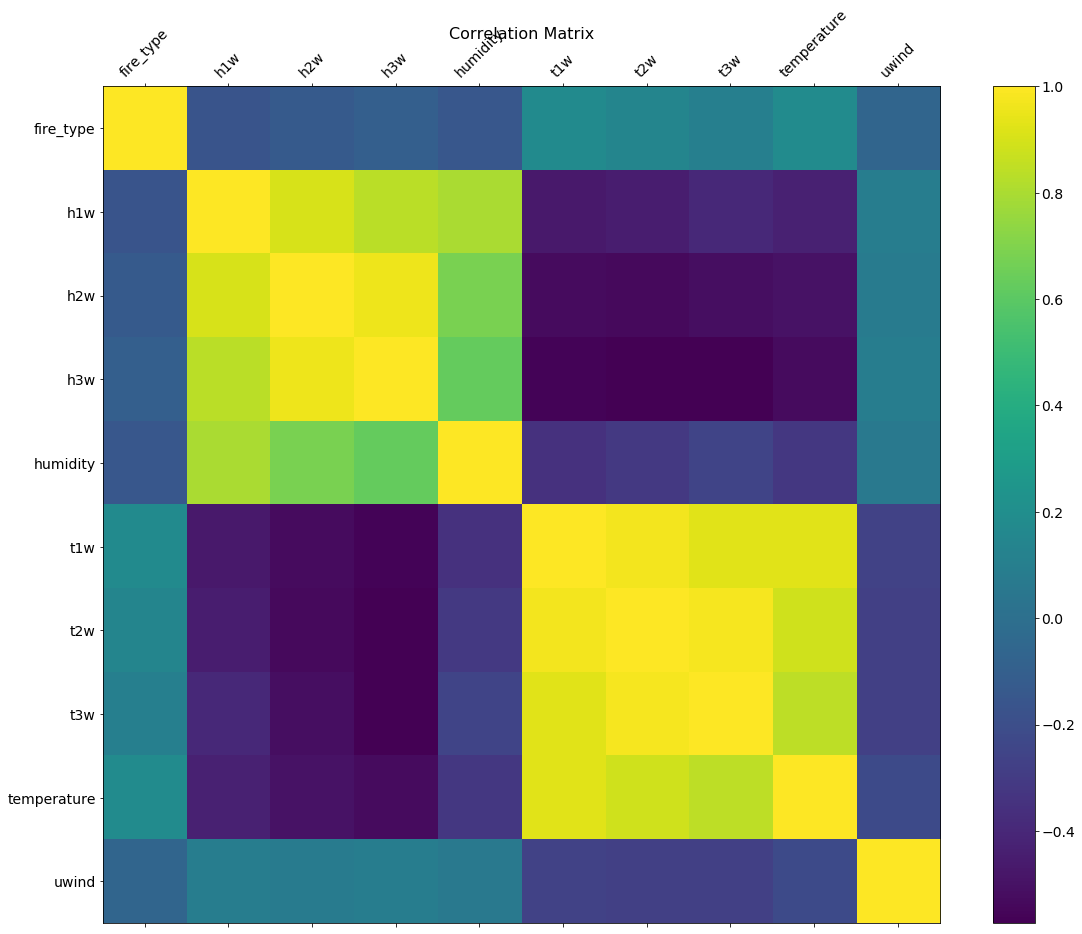

In [20]:
f = plt.figure(figsize=(19, 15))
corr = df_features_new.corr()
plt.matshow(corr, fignum=f.number)
plt.xticks(range(df_features_new.shape[1]), df_features_new.columns, fontsize=14, rotation=45)
plt.yticks(range(df_features_new.shape[1]), df_features_new.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [21]:
corr

,fire_type,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
fire_type,1.000000,-0.162350,-0.127990,-0.099373,-0.147559,0.180915,0.144525,0.106902,0.186752,-0.059322
h1w,-0.162350,1.000000,0.903487,0.835405,0.800387,-0.464036,-0.448013,-0.395083,-0.427055,0.090507
h2w,-0.127990,0.903487,1.000000,0.960677,0.685195,-0.529347,-0.535171,-0.512676,-0.494578,0.081013
h3w,-0.099373,0.835405,0.960677,1.000000,0.628182,-0.559436,-0.573497,-0.573604,-0.525253,0.094466
humidity,-0.147559,0.800387,0.685195,0.628182,1.000000,-0.349867,-0.313407,-0.253606,-0.317260,0.060488
t1w,0.180915,-0.464036,-0.529347,-0.559436,-0.349867,1.000000,0.969329,0.927232,0.929663,-0.264802
t2w,0.144525,-0.448013,-0.535171,-0.573497,-0.313407,0.969329,1.000000,0.978627,0.885960,-0.274093
t3w,0.106902,-0.395083,-0.512676,-0.573604,-0.253606,0.927232,0.978627,1.000000,0.842387,-0.275100
temperature,0.186752,-0.427055,-0.494578,-0.525253,-0.317260,0.929663,0.885960,0.842387,1.000000,-0.220748
uwind,-0.059322,0.090507,0.081013,0.094466,0.060488,-0.264802,-0.274093,-0.275100,-0.220748,1.000000


<p> Из матрицы можно заметить, что существует несколько признаков, которые слабокоррелируют с целевой функцией.</p>

<p> Делим на тестовую и тренировочную выборки и нормализуем данные, так как все данные у нас численные</p>

In [22]:
X = df_features_new.iloc[:, 1:].fillna(0)
y = df_features_new['fire_type']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

15974 6846


In [24]:
# нормализация
train_norm = X_train[X_train.columns]
test_norm = X_test[X_test.columns[0:10]]

std_scale = preprocessing.StandardScaler().fit(train_norm)
X_train_norm = std_scale.transform(train_norm)

training_norm_col = pd.DataFrame(X_train_norm, index=train_norm.index, columns=train_norm.columns) 
X_train.update(training_norm_col)
print (X_train.head())

# Нормализуем тестовые данные используя mean и stdev тренировочных данных
X_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(X_test_norm, index=test_norm.index, columns=test_norm.columns) 
X_test.update(testing_norm_col)
print (X_test.head())

/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
14126 -1.376053 -1.714298 -1.461760 -0.754131  2.007214  2.008775  1.834440   
14442 -1.093350 -1.841258 -2.102201  0.843389  2.494371  2.571975  2.456044   
15391 -0.680211 -0.604445 -0.784061  0.542097  1.025691  1.199949  1.162074   
7473   0.491628  0.844322  0.953849 -0.193104 -0.359849 -0.324471 -0.467146   
12559 -0.167110 -0.343673 -0.521744 -0.819522 -0.166044 -0.145970 -0.005761   

       temperature     uwind  
14126     1.927308 -0.650778  
14442     1.628198 -0.225970  
15391     0.914771 -0.004595  
7473      0.264756 -0.034508  
12559    -0.855586  0.390299  


/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
12395 -0.301791 -0.012919  0.050156 -0.390502  0.357883  0.315550  0.284840   
18549  1.667082  1.472218  0.980819  1.326189 -0.663217 -0.350845 -0.214699   
4003   0.635304  0.528377  0.596136  0.537207 -0.110365 -0.519804 -0.560575   
3184  -1.642833 -0.383104  0.164440 -1.675729 -0.678981 -0.600001 -0.863163   
283   -0.926729 -1.214189 -0.779109 -0.589734 -1.770864 -1.768226 -1.727530   

       temperature     uwind  
12395     0.463460  0.566803  
18549    -1.058518 -0.124257  
4003      0.617774  0.548854  
3184     -1.193805  1.350601  
283      -1.634543  0.300550  


In [25]:
X_train.describe()

,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
count,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04,1.597400e+04
mean,6.793114e-17,-9.580139e-17,9.120037e-17,6.397301e-17,-1.272427e-15,-2.458295e-15,2.476713e-15,-1.920031e-15,-5.004135e-18
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-2.584168e+00,-2.836432e+00,-2.736538e+00,-2.381596e+00,-5.061634e+00,-4.818160e+00,-4.480435e+00,-5.094932e+00,-5.111260e+00
25%,-6.791704e-01,-6.816147e-01,-6.602050e-01,-7.241839e-01,-5.497101e-01,-5.834272e-01,-5.868172e-01,-5.329596e-01,-4.892331e-01
50%,1.083176e-02,2.843453e-02,7.023367e-02,-5.193129e-02,-2.019415e-02,-4.592054e-02,-6.603348e-02,1.532259e-02,8.515430e-02
75%,6.980462e-01,7.383159e-01,7.478182e-01,6.948814e-01,6.265498e-01,5.725373e-01,5.774467e-01,6.864702e-01,6.176594e-01
max,2.901247e+00,2.786791e+00,2.692579e+00,2.854038e+00,2.637424e+00,2.617563e+00,2.501689e+00,2.485366e+00,3.444724e+00


In [26]:
X_train.head(5)

,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
14126,-1.376053,-1.714298,-1.461760,-0.754131,2.007214,2.008775,1.834440,1.927308,-0.650778
14442,-1.093350,-1.841258,-2.102201,0.843389,2.494371,2.571975,2.456044,1.628198,-0.225970
15391,-0.680211,-0.604445,-0.784061,0.542097,1.025691,1.199949,1.162074,0.914771,-0.004595
7473,0.491628,0.844322,0.953849,-0.193104,-0.359849,-0.324471,-0.467146,0.264756,-0.034508
12559,-0.167110,-0.343673,-0.521744,-0.819522,-0.166044,-0.145970,-0.005761,-0.855586,0.390299


In [30]:
%%time
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(weights='distance')
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.3995228459494218 25
CPU times: user 7.7 s, sys: 28 ms, total: 7.72 s
Wall time: 7.77 s


In [31]:
knn_20 = KNeighborsClassifier(n_neighbors = 20, weights='distance').fit(X_train, y_train)
err_train = np.mean(y_train != knn_20.predict(X_train))
err_test  = np.mean(y_test  != knn_20.predict(X_test))
Accuracy = knn_20.score(X_test, y_test)
print(err_train, err_test)
print(Accuracy, 'accuracy')

0.16983848754225617 0.39000876424189307
0.6099912357581069 accuracy


### Градиентный бустинг
<p>Результат вышел хуже, чем в knn с оптимально подобранным количеством соседей.</p>

In [32]:
fire_classifier = GradientBoostingClassifier(learning_rate=0.001, n_estimators=300)

In [33]:
fire_classifier.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [34]:
acc_boosting = fire_classifier.score(X_test, y_test)

In [35]:
y_test_predict = fire_classifier.predict(X_test)
err_train = np.mean(y_train != fire_classifier.predict(X_train))
err_test = np.mean(y_test != y_test_predict)

In [36]:
print('accuracy', acc_boosting)
print(err_train, err_test)

accuracy 0.35188431200701137
0.6325904594966821 0.6481156879929886


### Попытка улучшить baseline решение на основе feature selection с деревьями решений

In [37]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
New_features = model.transform(X)
model.get_support()
New_features.shape

(22820, 5)

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
Classifiers = [DecisionTreeClassifier(),LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),RandomForestClassifier(n_estimators=200)]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(pd.DataFrame(New_features), y , test_size = 0.3, random_state =  92)

In [39]:
%%time
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(weights='distance')
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train_sel, y_train_sel)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.39195060669920057 25
CPU times: user 5.43 s, sys: 12 ms, total: 5.44 s
Wall time: 5.58 s


In [40]:
knn_20 = KNeighborsClassifier(n_neighbors = 20, weights='distance').fit(X_train_sel, y_train_sel)
err_train = np.mean(y_train_sel != knn_20.predict(X_train_sel))
err_test  = np.mean(y_test_sel  != knn_20.predict(X_test_sel))
Accuracy = knn_20.score(X_test_sel, y_test_sel)
print(err_train, err_test)
print(Accuracy, 'accuracy')

0.16833604607487165 0.4006719252118025
0.5993280747881975 accuracy


<p> К сожалению не было получено никаких улучшений</p>

In [41]:
# пытаемся сбалансировать классы
df_features.groupby('fire_type').size()

fire_type
1      276
2       76
3      867
4     1588
5      300
6     4744
8     1994
9     5047
10    5212
11    2716
dtype: int64

In [42]:
df_major = df_features_new[df_features_new.fire_type==10]
df_minor_1 = df_features_new[df_features_new.fire_type==1]
df_minor_2 = df_features_new[df_features_new.fire_type==2]
df_minor_3 = df_features_new[df_features_new.fire_type==3]
df_minor_4 = df_features_new[df_features_new.fire_type==4]
df_minor_5 = df_features_new[df_features_new.fire_type==5]
df_minor_6 = df_features_new[df_features_new.fire_type==8]
df_minor_7 = df_features_new[df_features_new.fire_type==11]

In [43]:
df_minor_1 = resample(df_minor_1, replace=True, n_samples=5212, random_state=123)
df_minor_2 = resample(df_minor_2, replace=True, n_samples=5212, random_state=123)
df_minor_3 = resample(df_minor_3, replace=True, n_samples=5212, random_state=123)
df_minor_4 = resample(df_minor_4, replace=True, n_samples=5212, random_state=123)
df_minor_5 = resample(df_minor_5, replace=True, n_samples=5212, random_state=123)
df_minor_6 = resample(df_minor_6, replace=True, n_samples=5212, random_state=123)
df_minor_7 = resample(df_minor_7, replace=True, n_samples=5212, random_state=123)

In [44]:
df_balanced = pd.concat([df_major, df_minor_1, df_minor_2, df_minor_3, df_minor_4, df_minor_5, df_minor_6, df_minor_7])

In [45]:
df_balanced.head(5)

,fire_type,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
41,10,91.828568,61.877918,64.170006,81.709991,258.207184,280.482117,279.543854,258.330017,4.709991
44,10,92.690010,61.877918,64.170006,82.360001,260.480042,280.482117,279.543854,257.950012,6.339996
50,10,96.052849,95.645004,64.170006,93.110001,246.972870,250.001465,279.543854,250.309998,0.229996
54,10,93.772865,93.301437,64.170006,98.259995,254.678604,254.908600,279.543854,243.360001,1.429993
58,10,88.314293,88.650711,64.170006,96.809998,244.970001,251.777161,279.543854,241.580002,-1.720001


In [46]:
X_bal = df_balanced.iloc[:, 1:].fillna(0)
y_bal = df_balanced['fire_type']

In [47]:
df_balanced['fire_type']

41       10
44       10
50       10
54       10
58       10
59       10
62       10
71       10
72       10
101      10
107      10
119      10
142      10
161      10
178      10
181      10
186      10
194      10
220      10
230      10
236      10
239      10
252      10
276      10
279      10
282      10
290      10
291      10
292      10
295      10
         ..
15265    11
5153     11
6334     11
6110     11
16521    11
20803    11
19211    11
16841    11
184      11
19773    11
12443    11
5409     11
3958     11
4585     11
5055     11
16949    11
13128    11
21567    11
16567    11
15874    11
15330    11
19052    11
5723     11
15731    11
11514    11
15029    11
20971    11
5503     11
4242     11
9441     11
Name: fire_type, Length: 41696, dtype: int64

In [48]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size = 0.3, random_state = 42)
N_train_bal, _ = X_train_bal.shape 
N_test_bal,  _ = X_test_bal.shape 
print(N_train_bal, N_test_bal)

29187 12509


In [49]:
# нормализация
train_norm_bal = X_train_bal[X_train_bal.columns]
test_norm_bal = X_test_bal[X_test_bal.columns[0:10]]

std_scale = preprocessing.StandardScaler().fit(train_norm_bal)
X_train_norm_bal = std_scale.transform(train_norm_bal)

training_norm_col_bal = pd.DataFrame(X_train_norm_bal, index=train_norm_bal.index, columns=train_norm_bal.columns) 
X_train_bal.update(training_norm_col_bal)
print (X_train_bal.head())

# Нормализуем тестовые данные используя mean и stdev тренировочных данных
X_test_norm_bal = std_scale.transform(test_norm_bal)
testing_norm_col_bal = pd.DataFrame(X_test_norm_bal, index=test_norm_bal.index, columns=test_norm_bal.columns) 
X_test_bal.update(testing_norm_col_bal)
print (X_test_bal.head())

/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
18392  0.564663  0.814660  0.620139  0.244773  0.128417  0.269970  0.211939   
17114  0.005480 -0.633955 -0.831464  0.216606  1.069762  1.232100  1.361544   
20066  0.042024 -0.045292  0.035410 -0.187826  0.127684  0.037892  0.161785   
22237 -0.914760 -1.556729 -0.931536 -0.323877 -0.629711 -0.760438 -0.565159   
18460  0.075265  0.127186 -0.006972  0.130511  0.618271  0.621385  0.740919   

       temperature     uwind  
18392    -0.335460  1.050398  
17114     0.518163  0.926275  
20066     0.296533 -0.349100  
22237    -0.737992  1.885133  
18460     0.653644  0.094641  


/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
14852 -0.569027 -0.059300 -0.323348 -0.498724  1.201921  1.052179  1.252223   
893    1.010743  1.158050  1.400629  1.148235 -1.151768 -1.353445 -1.675588   
18608 -0.063952  0.258462  0.250811  0.024753  0.256483  0.433952  0.412302   
21635  1.628751  1.117040  1.041874  1.800853 -1.356098 -1.072442 -0.859622   
21941 -0.791849  0.136514  0.430596 -1.419192 -0.743846 -0.473816 -0.425443   

       temperature     uwind  
14852     1.270757 -0.777330  
893      -0.550821  0.467017  
18608     0.349786  0.044995  
21635    -2.134327  0.823872  
21941    -0.651847 -0.072924  


In [50]:
X_train_bal.describe()

,h1w,h2w,h3w,humidity,t1w,t2w,t3w,temperature,uwind
count,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04,2.918700e+04
mean,2.345212e-16,-3.059114e-16,5.403108e-16,-9.001757e-17,-7.071239e-16,-9.370804e-16,2.135043e-15,8.793840e-16,6.054171e-17
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-2.671624e+00,-2.830858e+00,-2.786878e+00,-2.317871e+00,-3.821320e+00,-3.957593e+00,-3.857956e+00,-3.566688e+00,-4.898251e+00
25%,-7.622583e-01,-7.025435e-01,-6.498869e-01,-8.213127e-01,-4.688024e-01,-4.757768e-01,-5.016618e-01,-5.116665e-01,-4.980479e-01
50%,2.482049e-02,7.558576e-02,9.536647e-02,-4.911835e-02,1.153405e-01,8.046295e-02,2.608617e-02,1.383399e-01,6.051164e-02
75%,7.492465e-01,7.142339e-01,7.065084e-01,7.618715e-01,6.876165e-01,6.832580e-01,6.780026e-01,7.249122e-01,6.283754e-01
max,2.157629e+00,2.174755e+00,2.218587e+00,2.118128e+00,2.159419e+00,2.192528e+00,2.151725e+00,1.999859e+00,3.548397e+00


In [51]:
%%time
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(weights='distance')
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train_bal, y_train_bal)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.1213208186021435 15
CPU times: user 17.6 s, sys: 68 ms, total: 17.7 s
Wall time: 17.7 s


In [52]:
knn_15 = KNeighborsClassifier(n_neighbors = 15, weights='distance').fit(X_train_bal, y_train_bal)
err_train = np.mean(y_train_bal != knn_15.predict(X_train_bal))
err_test  = np.mean(y_test_bal  != knn_15.predict(X_test_bal))
Accuracy = knn_15.score(X_test_bal, y_test_bal)
print(err_train, err_test)
print(Accuracy, 'accuracy')

0.07654092575461678 0.1187944679830522
0.8812055320169478 accuracy


KNN:
Хороший для baseline решения
Сильно зависит от нормализации и балансировки классов
Подвержен curse of dimensionality
Следует проработать значимые признаки, тогда решение вероятно улучшится и ускорится

К сожалению в моем случае не удалось получить после балансировки классов лучший результат. На тренировачном наборе данных результат улучшился, однако на тестовом сильно упал.
Значит ресемплинг классов производился неверно.

# Laba 2 PCA on several models (SVM and etc...)

In [105]:
# import modules
import numpy as np
import pandas as pd
import xarray
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import requests
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample
from sklearn.svm import SVC

%matplotlib inline

In [106]:
ncep_data = []
year = 2018
for var in ('air', 'uwnd', 'rhum'):
    dataset_filename = '/home/topus/Desktop/Ml_tasks_Zolotykh/{}.{}.nc'.format(var, year)
    ncep_data.append(xarray.open_dataset(dataset_filename))
ncep_data = xarray.merge(ncep_data)

/home/topus/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/topus/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'uwnd' has multiple fill values {-99, 32767}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/topus/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'rhum' has multiple fill values {-99, 32767}, decoding all values to NaN.
  use_cftime=use_cftime,


In [107]:
def extract_features(row):
    point = ncep_data.sel(
        lon=row['longitude'],
        lat=row['latitude'],
        level=1000,
        method='nearest',
    )

    p1w = point.rolling(time=7).mean()
    p2w = point.rolling(time=14).mean()
    p3w = point.rolling(time=21).mean()
    
    date = row['date']
    v = point.sel(time=date)
    v1w = p1w.sel(time=date)
    v2w = p2w.sel(time=date)
    v3w = p3w.sel(time=date)
    
    return {
        'fire_type': row['fire_type'],
        'fire_type_name': row['fire_type_name'],
        'date': row['date'], 
        'temperature': v.air.values.item(0),
        'humidity': v.rhum.values.item(0),
        'uwind': v.uwnd.values.item(0),
        't1w': v1w.air.values.item(0),
        't2w': v2w.air.values.item(0),
        't3w': v3w.air.values.item(0),
        'h1w': v1w.rhum.values.item(0),
        'h2w': v2w.rhum.values.item(0),
        'h3w': v3w.rhum.values.item(0)
    }

In [108]:
# load data
df_train = pd.read_csv('/home/topus/zolotyh/data/wildfires_train.csv')
df_subsample = df_train.query('(date >= "2018") & (date <= "2019")')

df_features = []
for i, row in tqdm(df_subsample.iterrows(), total=df_subsample.shape[0]):
    features = extract_features(row)
    df_features.append(features)

df_features = pd.DataFrame(df_features)

In [109]:
df_raw = df_features.copy()

In [110]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22820 entries, 0 to 22819
Data columns (total 12 columns):
date              22820 non-null object
fire_type         22820 non-null int64
fire_type_name    22820 non-null object
h1w               22802 non-null float64
h2w               22773 non-null float64
h3w               22737 non-null float64
humidity          22820 non-null float64
t1w               22802 non-null float64
t2w               22773 non-null float64
t3w               22737 non-null float64
temperature       22820 non-null float64
uwind             22820 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 2.1+ MB


In [111]:
df_raw.isnull().sum()

date               0
fire_type          0
fire_type_name     0
h1w               18
h2w               47
h3w               83
humidity           0
t1w               18
t2w               47
t3w               83
temperature        0
uwind              0
dtype: int64

In [112]:
# Требуется убрать пустые значения или заполнить. 
# Выбираем самый простой путь заполнения медиана.
df_raw = df_raw.fillna(df_raw.median(axis = 0), axis = 0)

In [113]:
df_raw.isnull().sum()

date              0
fire_type         0
fire_type_name    0
h1w               0
h2w               0
h3w               0
humidity          0
t1w               0
t2w               0
t3w               0
temperature       0
uwind             0
dtype: int64

In [63]:
X = df_features_new.iloc[:, 1:]
y = df_features_new['fire_type']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

15974 6846


In [67]:
# нормализация
train_norm = X_train[X_train.columns]
test_norm = X_test[X_test.columns[0:10]]

std_scale = preprocessing.StandardScaler().fit(train_norm)
X_train_norm = std_scale.transform(train_norm)

training_norm_col = pd.DataFrame(X_train_norm, index=train_norm.index, columns=train_norm.columns) 
X_train.update(training_norm_col)
print (X_train.head())

# Нормализуем тестовые данные используя mean и stdev тренировочных данных
X_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(X_test_norm, index=test_norm.index, columns=test_norm.columns) 
X_test.update(testing_norm_col)
print (X_test.head())

/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
14126 -1.376053 -1.714298 -1.461760 -0.754131  2.007214  2.008775  1.834440   
14442 -1.093350 -1.841258 -2.102201  0.843389  2.494371  2.571975  2.456044   
15391 -0.680211 -0.604445 -0.784061  0.542097  1.025691  1.199949  1.162074   
7473   0.491628  0.844322  0.953849 -0.193104 -0.359849 -0.324471 -0.467146   
12559 -0.167110 -0.343673 -0.521744 -0.819522 -0.166044 -0.145970 -0.005761   

       temperature     uwind  
14126     1.927308 -0.650778  
14442     1.628198 -0.225970  
15391     0.914771 -0.004595  
7473      0.264756 -0.034508  
12559    -0.855586  0.390299  


/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
12395 -0.301791 -0.012919  0.050156 -0.390502  0.357883  0.315550  0.284840   
18549  1.667082  1.472218  0.980819  1.326189 -0.663217 -0.350845 -0.214699   
4003   0.635304  0.528377  0.596136  0.537207 -0.110365 -0.519804 -0.560575   
3184  -1.642833 -0.383104  0.164440 -1.675729 -0.678981 -0.600001 -0.863163   
283   -0.926729 -1.214189 -0.779109 -0.589734 -1.770864 -1.768226 -1.727530   

       temperature     uwind  
12395     0.463460  0.566803  
18549    -1.058518 -0.124257  
4003      0.617774  0.548854  
3184     -1.193805  1.350601  
283      -1.634543  0.300550  


### SVM without PCA

In [68]:
clf = SVC()

In [69]:
%%time
clf.fit(X_train, y_train)
err_train = np.mean(y_train != clf.predict(X_train))
err_test = np.mean(y_test != clf.predict(X_test))
Accuracy = clf.score(X_test, y_test)
print("err_train & err_test")
print(err_train, err_test)
print(Accuracy, "accuracy")

err_train & err_test
0.5301740328033053 0.5382705229330996
0.4617294770669004 accuracy
CPU times: user 34.9 s, sys: 216 ms, total: 35.1 s
Wall time: 35.3 s


In [70]:
clf

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### degree = 3 потому что, обычно полинома 3 степени хватает, чтобы получить хорошие результаты, для большей степени нужно чтобы выборка обучающая была больше

#### Матрица ошибок

In [71]:
conf_m = confusion_matrix(y_test,clf.predict(X_test))
conf_m

array([[  0,   0,   0,  33,   0,   9,   0,  17,  11,   5],
       [  0,   0,   0,   7,   0,   1,   1,   9,   2,   2],
       [  0,   0,   0,  42,   0,  33,  10, 105,  48,  20],
       [  0,   0,   0, 258,   0,  22,   0,  26, 134,  13],
       [  0,   0,   0,  35,   0,  13,   1,  17,  31,   3],
       [  0,   0,   0,  48,   0, 809,  38, 254, 298,  25],
       [  0,   0,   0,   3,   0,  89, 198, 225, 102,   6],
       [  0,   0,   0,  37,   0, 291,  53, 893, 190,  28],
       [  1,   0,   0,  63,   0, 214,  82, 234, 955,  16],
       [  0,   0,   0,  30,   0,  98,   8, 484, 118,  48]])

In [91]:
labels_ = sorted(df_features['fire_type'].unique().tolist())

In [92]:
labels_

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

In [93]:
y_pred = clf.predict(X_test)

In [100]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_test, y_pred,labels=labels_)

### Normalized

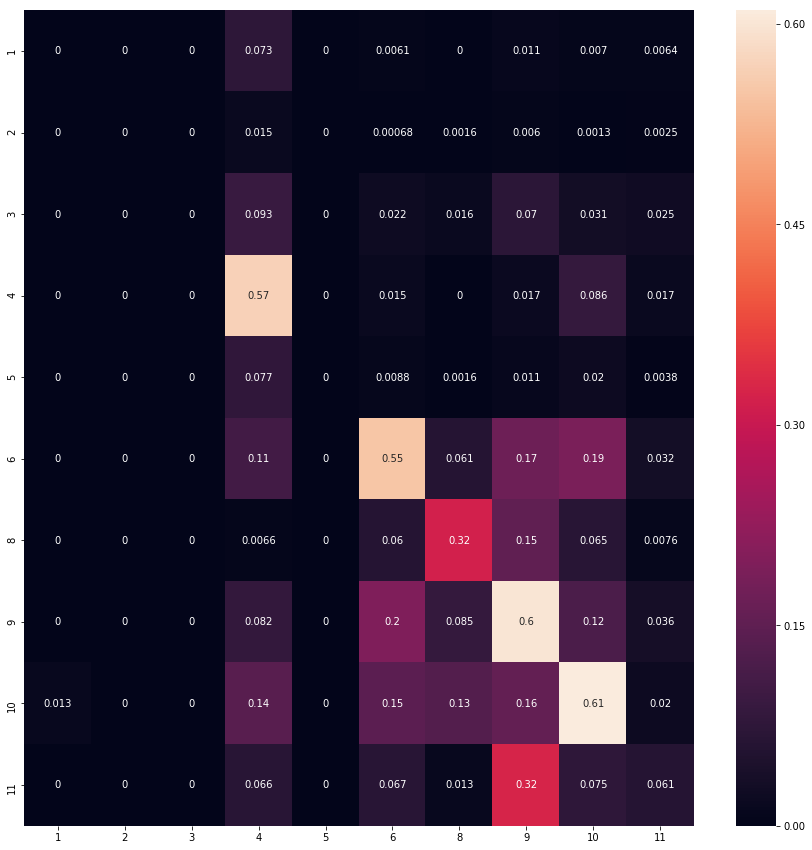

In [105]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

### Using PCA for SVM

In [173]:
from sklearn.decomposition import PCA
SEED = 42

In [174]:
pca = PCA(n_components='mle', random_state=SEED)# adjust yourself

In [175]:
X_t = pca.fit_transform(X)

In [129]:
print(pca.explained_variance_ratio_)
X_train_t, X_test_t, y_train_pca, y_test_pca = train_test_split(X_t, y, test_size = 0.3, random_state = 42)

[0.68626273 0.18924663 0.07613167 0.01969519 0.01290029 0.00870709
 0.00402939 0.00246287]


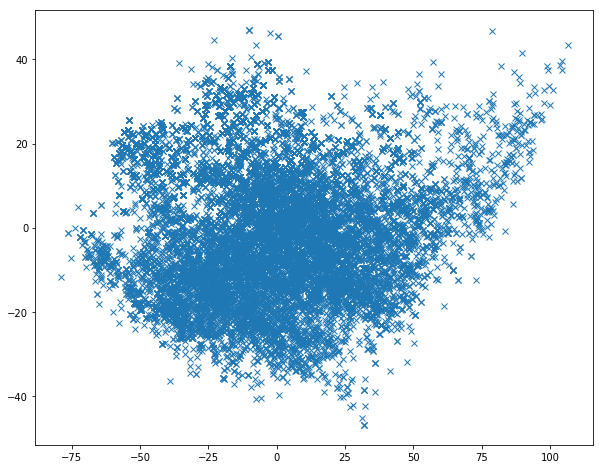

In [130]:
plt.figure(figsize=(10,8))
plt.plot(X_t[:,0], X_t[:,1], 'x')
plt.show()

In [148]:
svm = SVC()
svm.fit(X_train_t, y_train)
err_train = np.mean(y_train_pca != svm.predict(X_train_t))
err_test = np.mean(y_test_pca != svm.predict(X_test_t))
Accuracy = svm.score(X_test_t, y_test_pca)
print("err_train & err_test")
print(err_train, err_test)
print(Accuracy, "accuracy")

err_train & err_test
0.5439464129209967 0.5522933099620216
0.44770669003797836 accuracy


###### SVM results without pca
err_train & err_test
<br>0.5301740328033053 0.5382705229330996
<br>0.4617294770669004 accuracy

In [149]:
svm

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [150]:
y_pred_pca = svm.predict(X_test_t)

In [151]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_test_pca, y_pred_pca,labels=labels_)

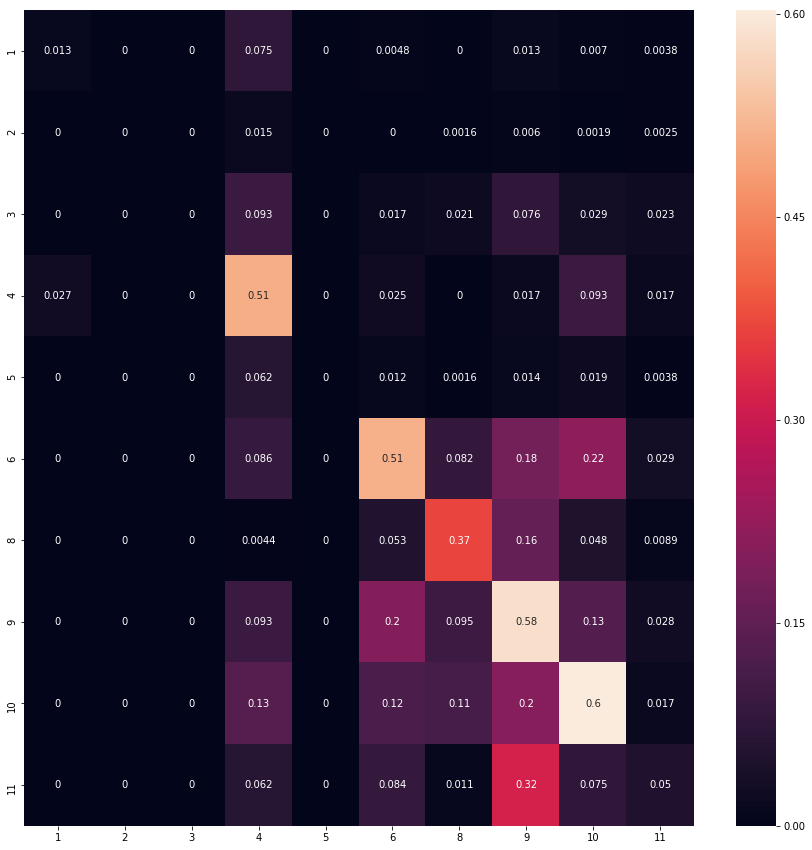

In [152]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

### Вывод: При использовании PCA ошибка на train увеличилась ~ на 1% и на test ~1%, а точность упала ~ на 1.5%
#### Также можно заметить по матрице рассогласований, что результаты ухудшились

### Using PCA for KNN (model with the best results from LABA#1)

In [153]:
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(weights='distance')
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train_t, y_train_pca)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.4013391818044315 15


In [154]:
knn_15 = KNeighborsClassifier(n_neighbors = 15, weights='distance').fit(X_train_t, y_train_pca)
err_train = np.mean(y_train_pca != knn_15.predict(X_train_t))
err_test  = np.mean(y_test_pca  != knn_15.predict(X_test_t))
Accuracy = knn_15.score(X_test_t, y_test_pca)
print(err_train, err_test)
print(Accuracy, 'accuracy')

0.17040190309252534 0.3954133800759568
0.6045866199240433 accuracy


#### KNN results without pca
0.16983848754225617 0.39000876424189307
<br>0.6099912357581069 accuracy

In [156]:
y_pred_pca = knn_15.predict(X_test_t)
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_test_pca, y_pred_pca,labels=labels_)

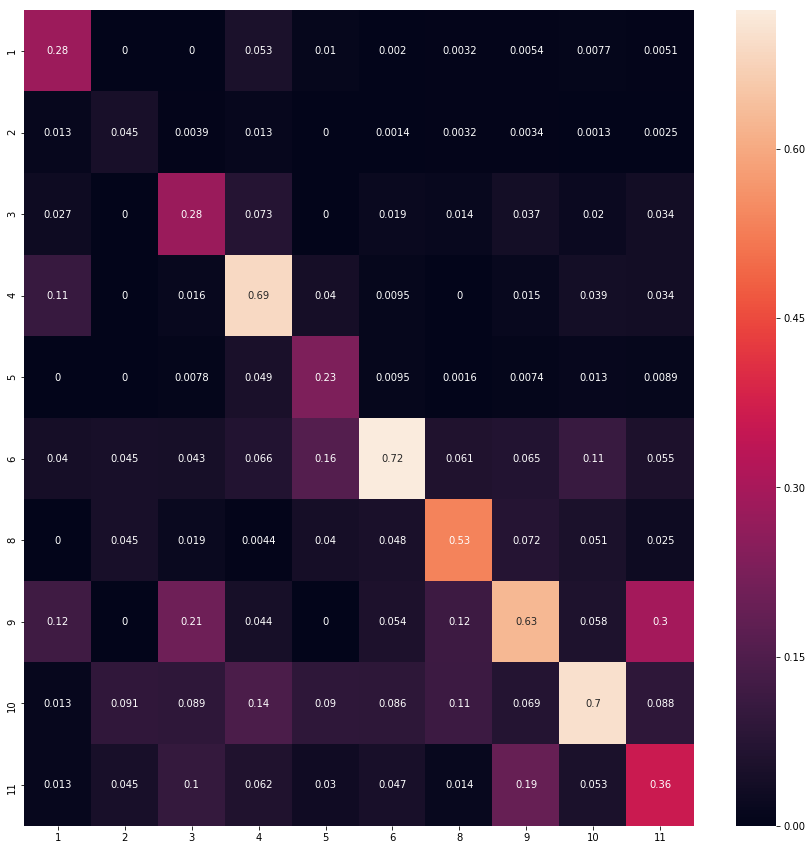

In [157]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

### Вывод: Использование PCA ухудшает результат KNN без PCA незначительно. 

#### Возьмем 2 компоненты 

In [159]:
pca = PCA(n_components=2, random_state=SEED)

In [160]:
X_t = pca.fit_transform(X)

In [161]:
print(pca.explained_variance_ratio_)
X_train_t, X_test_t, y_train_pca, y_test_pca = train_test_split(X_t, y, test_size = 0.3, random_state = 42)

[0.68626273 0.18924663]


две компоненты имеют высокую объясненную вариацию

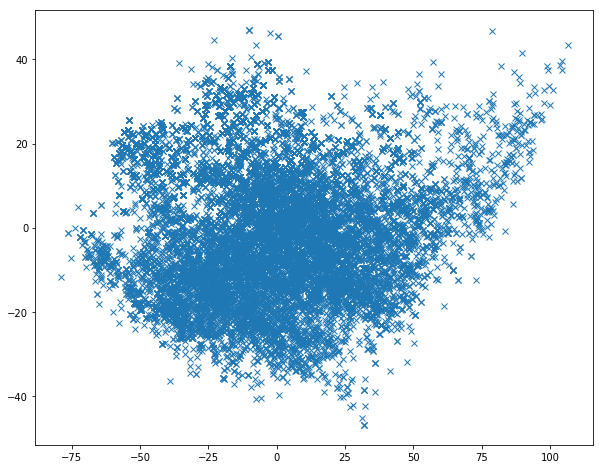

In [162]:
plt.figure(figsize=(10,8))
plt.plot(X_t[:,0], X_t[:,1], 'x')
plt.show()

### пробуем KNN c 2 компонентами

In [163]:
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(weights='distance')
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train_t, y_train_pca)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.41867910968861355 55


Опмтимальное количество соседей 55

In [164]:
knn_55 = KNeighborsClassifier(n_neighbors = 55, weights='distance').fit(X_train_t, y_train_pca)
err_train = np.mean(y_train_pca != knn_55.predict(X_train_t))
err_test  = np.mean(y_test_pca  != knn_55.predict(X_test_t))
Accuracy = knn_55.score(X_test_t, y_test_pca)
print(err_train, err_test)
print(Accuracy, 'accuracy')

0.16977588581444847 0.40899795501022496
0.591002044989775 accuracy


Получаем результат хуже, чем без использования PCA

In [165]:
y_pred_pca = knn_55.predict(X_test_t)
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_test_pca, y_pred_pca,labels=labels_)

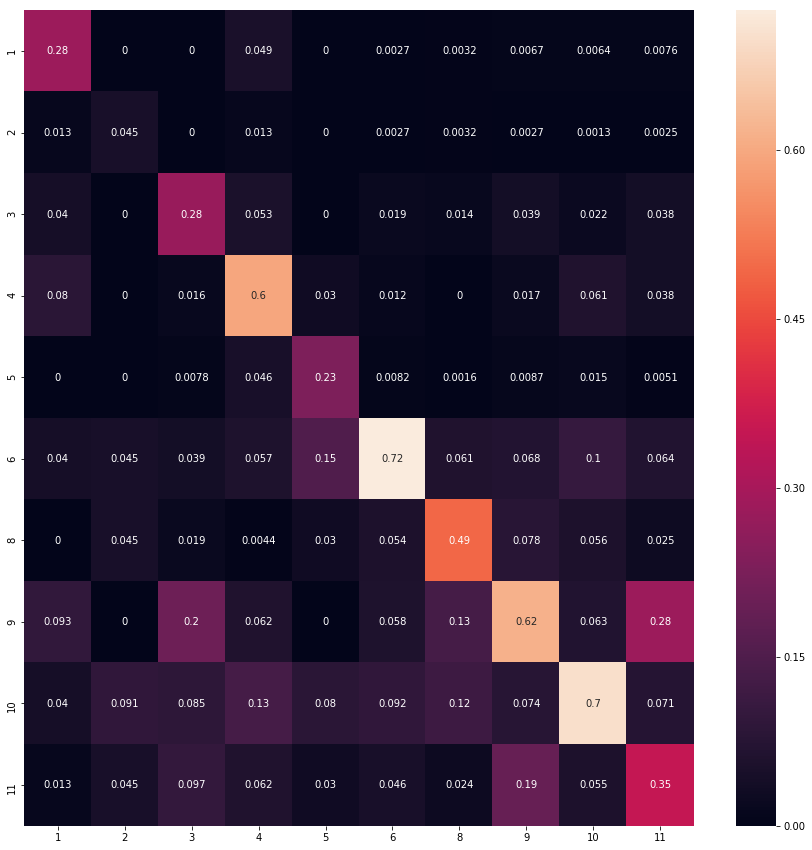

In [166]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

#### 9 компонентов

In [167]:
pca = PCA(n_components=9, random_state=SEED)
X_t = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
X_train_t, X_test_t, y_train_pca, y_test_pca = train_test_split(X_t, y, test_size = 0.3, random_state = 42)

[6.86262725e-01 1.89246629e-01 7.61316655e-02 1.96951927e-02
 1.29002884e-02 8.70708694e-03 4.02939398e-03 2.46286517e-03
 5.64153150e-04]


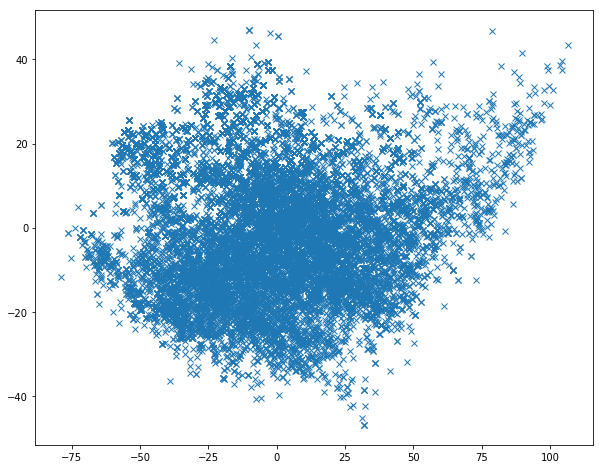

In [168]:
plt.figure(figsize=(10,8))
plt.plot(X_t[:,0], X_t[:,1], 'x')
plt.show()

#### knn c 9 компонентами

In [169]:
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(weights='distance')
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train_t, y_train_pca)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.4012138294345704 15


In [170]:
knn_15 = KNeighborsClassifier(n_neighbors = 15, weights='distance').fit(X_train_t, y_train_pca)
err_train = np.mean(y_train_pca != knn_15.predict(X_train_t))
err_test  = np.mean(y_test_pca  != knn_15.predict(X_test_t))
Accuracy = knn_15.score(X_test_t, y_test_pca)
print(err_train, err_test)
print(Accuracy, 'accuracy')

0.17040190309252534 0.39570552147239263
0.6042944785276073 accuracy


In [171]:
y_pred_pca = knn_15.predict(X_test_t)
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_test_pca, y_pred_pca,labels=labels_)

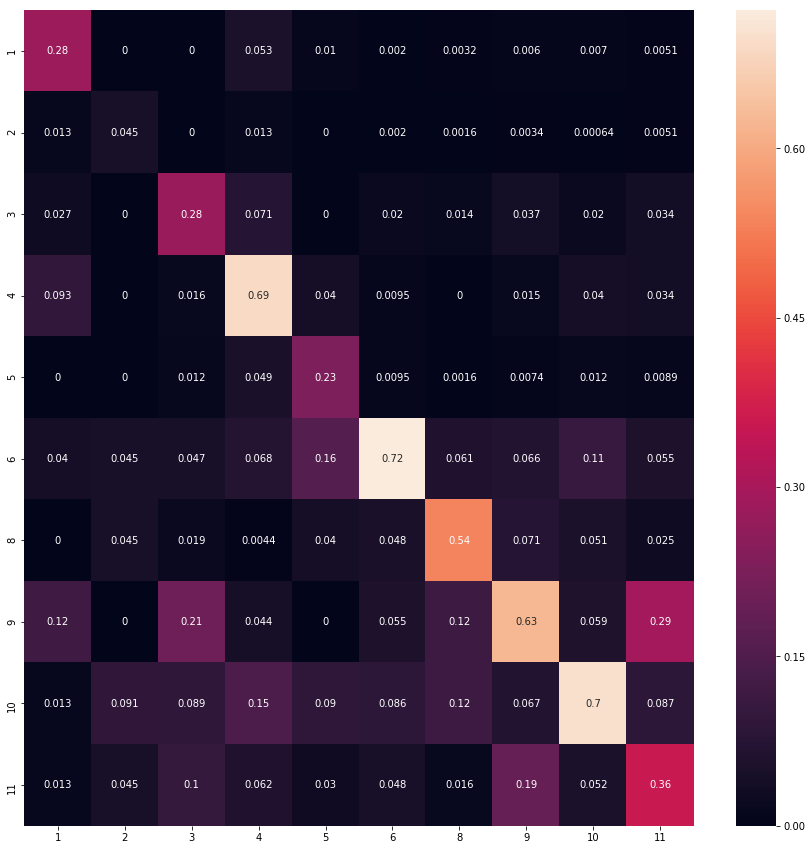

In [172]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

Самые лучшие результаты получили, если n_components выставить равным "mle", однако pca не дает улучшений для алгоритма Ближайших соседей и SVM в данном случае

# Lab3 запускаем сетку из 1-3 полносвязанных слоев и пытаемся подобрать некоторые гиперпараметры

In [27]:
from sklearn.neural_network import MLPClassifier

In [82]:
df_features.to_csv('new_data.csv')

Сильно урезали датасет и оставили одинаковое количество наблюдений для 5 классов, чтобы оверфитить модель. Если модель оверфитится, то она будет обучаться

In [95]:
new_data = pd.read_csv('new_data.csv')

In [96]:
new_data.shape

(25, 10)

In [97]:
new_data.groupby('fire_type').size()

fire_type
1    5
2    5
3    5
4    5
5    5
dtype: int64

In [98]:
X = new_data.iloc[:, 1:]
y = new_data['fire_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

17 8


In [99]:
X.columns

Index(['h1w', 'h2w', 'h3w', 'humidity', 't1w', 't2w', 't3w', 'temperature',
       'uwind'],
      dtype='object')

In [100]:
# нормализация
train_norm = X_train[X_train.columns]
test_norm = X_test[X_test.columns[0:10]]

std_scale = preprocessing.StandardScaler().fit(train_norm)
X_train_norm = std_scale.transform(train_norm)

training_norm_col = pd.DataFrame(X_train_norm, index=train_norm.index, columns=train_norm.columns) 
X_train.update(training_norm_col)
print (X_train.head())

# Нормализуем тестовые данные используя mean и stdev тренировочных данных
X_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(X_test_norm, index=test_norm.index, columns=test_norm.columns) 
X_test.update(testing_norm_col)
print (X_test.head())

/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


         h1w       h2w  h3w  humidity       t1w       t2w  t3w  temperature  \
22  0.792955  1.961091  0.0  0.309762 -0.925394 -2.299161  0.0    -1.097378   
5  -1.049167 -0.462105  0.0  0.517448  1.022898  0.447376  0.0     0.354620   
2  -1.049167 -0.462105  0.0  0.730359  1.022898  0.447376  0.0    -0.328967   
12  0.674108 -0.462105  0.0 -0.208147 -0.907695  0.447376  0.0    -0.218196   
15  0.979371 -0.462105  0.0  0.424707 -0.887376  0.447376  0.0     0.904482   

       uwind  
22  0.799119  
5   0.037302  
2   0.032901  
12 -0.081597  
15  0.226652  


/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


         h1w       h2w  h3w  humidity       t1w       t2w  t3w  temperature  \
8  -1.049167 -0.462105  0.0  0.284291  1.022898  0.447376  0.0     0.459403   
16  1.034209 -0.462105  0.0  0.503733 -0.828097  0.447376  0.0     1.051179   
0  -1.049167 -0.462105  0.0 -0.030504  1.022898  0.447376  0.0     0.085177   
23  1.168546  2.442292  0.0  0.659170 -1.451483 -3.524797  0.0    -1.533476   
11  0.951684  2.244809  0.0  0.289516 -0.665023 -2.177773  0.0     0.269795   

       uwind  
8  -0.319387  
16  0.116563  
0  -0.521955  
23  0.072531  
11 -0.024348  


In [101]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [102]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [103]:
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.0
test error: 0.625


In [104]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  1.0
test accuracy:  0.375


### Вывод:
Из-за малого количества данных, можно заметить что модель переобучилась, потому что ошибка на тренировочной выборке 0, т.е. классификатор заточился под тренировочную выборку.
Таким образом, легко и быстро мы узнаем, будет ли успешно обучаться наша сетка

data ######################################################################

In [114]:
X = df_features_new.iloc[:, 1:]
y = df_features_new['fire_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

15974 6846


In [115]:
# нормализация
train_norm = X_train[X_train.columns]
test_norm = X_test[X_test.columns[0:10]]

std_scale = preprocessing.StandardScaler().fit(train_norm)
X_train_norm = std_scale.transform(train_norm)

training_norm_col = pd.DataFrame(X_train_norm, index=train_norm.index, columns=train_norm.columns) 
X_train.update(training_norm_col)
print (X_train.head())

# Нормализуем тестовые данные используя mean и stdev тренировочных данных
X_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(X_test_norm, index=test_norm.index, columns=test_norm.columns) 
X_test.update(testing_norm_col)
print (X_test.head())

/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
14126 -1.376053 -1.714298 -1.461760 -0.754131  2.007214  2.008775  1.834440   
14442 -1.093350 -1.841258 -2.102201  0.843389  2.494371  2.571975  2.456044   
15391 -0.680211 -0.604445 -0.784061  0.542097  1.025691  1.199949  1.162074   
7473   0.491628  0.844322  0.953849 -0.193104 -0.359849 -0.324471 -0.467146   
12559 -0.167110 -0.343673 -0.521744 -0.819522 -0.166044 -0.145970 -0.005761   

       temperature     uwind  
14126     1.927308 -0.650778  
14442     1.628198 -0.225970  
15391     0.914771 -0.004595  
7473      0.264756 -0.034508  
12559    -0.855586  0.390299  


/home/topus/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


            h1w       h2w       h3w  humidity       t1w       t2w       t3w  \
12395 -0.301791 -0.012919  0.050156 -0.390502  0.357883  0.315550  0.284840   
18549  1.667082  1.472218  0.980819  1.326189 -0.663217 -0.350845 -0.214699   
4003   0.635304  0.528377  0.596136  0.537207 -0.110365 -0.519804 -0.560575   
3184  -1.642833 -0.383104  0.164440 -1.675729 -0.678981 -0.600001 -0.863163   
283   -0.926729 -1.214189 -0.779109 -0.589734 -1.770864 -1.768226 -1.727530   

       temperature     uwind  
12395     0.463460  0.566803  
18549    -1.058518 -0.124257  
4003      0.617774  0.548854  
3184     -1.193805  1.350601  
283      -1.634543  0.300550  


### Init model

## 1 Полносвязанный слой с количеством нейронов 100

In [56]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Check classificator

In [57]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

Train and test errors

In [58]:
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.5550269187429573
test error: 0.5579900671925212


Accuracy

In [59]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.4449730812570427
test accuracy:  0.4420099328074788


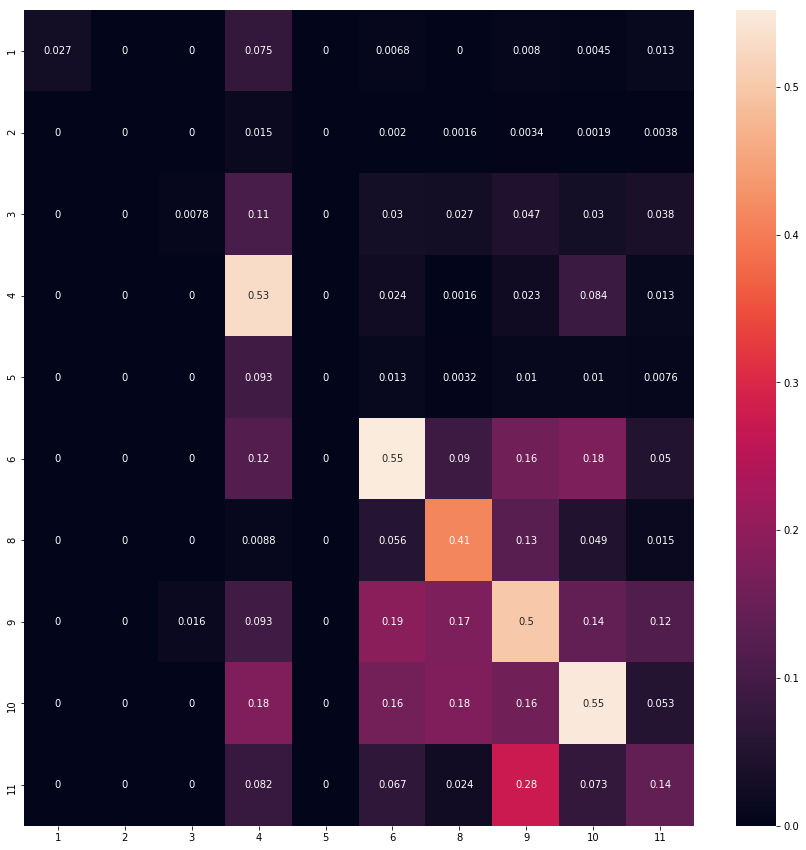

In [60]:
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

### Подбор гиперпараметров
Подбираем параметр регуляризации alpha

In [34]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


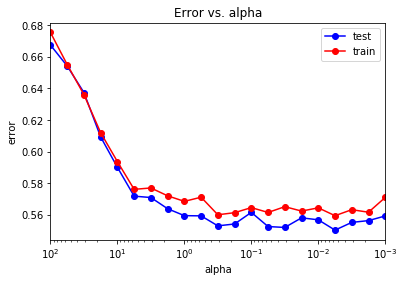

In [35]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

### Minimum error

In [36]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.5503317891573808 0.5594507741747006


### Optimal alpha

In [37]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.00562341]


In [38]:
alpha_opt = alpha_opt[0]

### Сетка с оптимальным alpha

In [41]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [42]:
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.5503317891573808
test error: 0.5594507741747006


In [43]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.44966821084261926
test accuracy:  0.44054922582529943


# Выводы
Мы создали лист в котором хранили разные возможные значения параметра alpha. И оказалось, что дефолтное значение параметра alpha = 0.0001 лучше, чем 0.00562341, которое мы подобрали. Для наглядности распечатаем матрицу рассогласований.

In [44]:
labels_ = sorted(df_features['fire_type'].unique().tolist())

In [46]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)

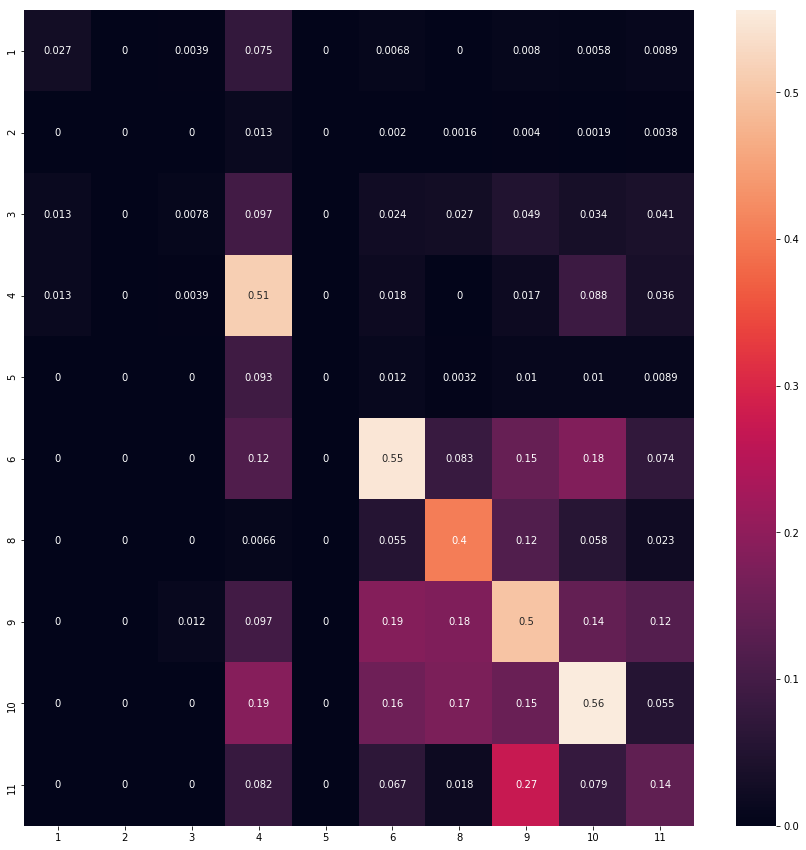

In [47]:
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

### попробуем с alpha = 2 * 10^(-5)

In [49]:
alpha_ = 0.00002
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', activation = 'logistic', random_state = 42, alpha=alpha_)
mlp_model.fit(X_train, y_train)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=2e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [50]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [51]:
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.5550269187429573
test error: 0.5622261174408414


In [52]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.4449730812570427
test accuracy:  0.4377738825591586


## Вывод:
Дефолтное значение alpha=0.0001 дает лучшие результаты. Также распечатаем confusion matrix и попробуем использовать другой solver и также проведем эксперимент с другой функцией активации.  

In [54]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)

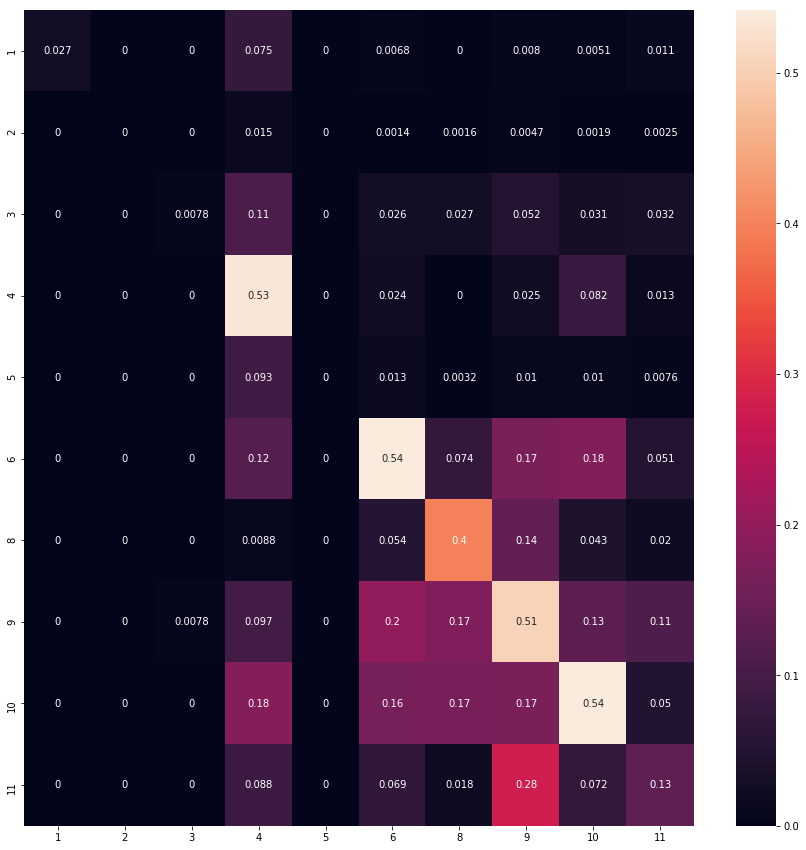

In [55]:
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

Можно заметить, что предсказание классов незначительно ухудшилось по сравнению с предыдущими примерами.
Также можно заметить, что 6,9,10 классы определяются лучше всех, потому что наблюдений в тренировочном датасете для этих классов больше

In [63]:
df_features.groupby('fire_type').size()

fire_type
1      276
2       76
3      867
4     1588
5      300
6     4744
8     1994
9     5047
10    5212
11    2716
dtype: int64

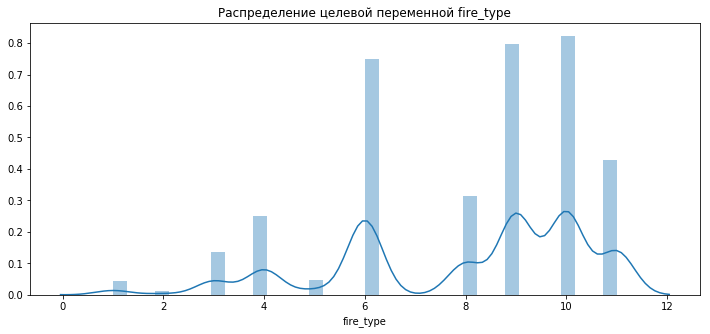

In [64]:
plt.figure(figsize=(12,5))
plt.title("Распределение целевой переменной fire_type")
ax = sns.distplot(df_features["fire_type"])

### GridSearchCV on the same alpha_arr

In [73]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', activation = 'logistic', random_state = 42)
grid = GridSearchCV(mlp_model, param_grid={'alpha': alpha_arr}, cv=3)
grid.fit(X_train, y_train)
best_cv_err = 1 - grid.best_score_
best_alpha = grid.best_estimator_.alpha

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):

In [75]:
# лучшее Альфа по кросс-валидации
best_alpha

0.03162277660168379

In [76]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', activation = 'logistic', random_state = 42, alpha=best_alpha)
mlp_model.fit(X_train, y_train)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=0.03162277660168379,
              batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(100,),
              learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=42,
              shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [77]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [78]:
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.5520220358081883
test error: 0.5651475314052001


In [79]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.4479779641918117
test accuracy:  0.43485246859479987


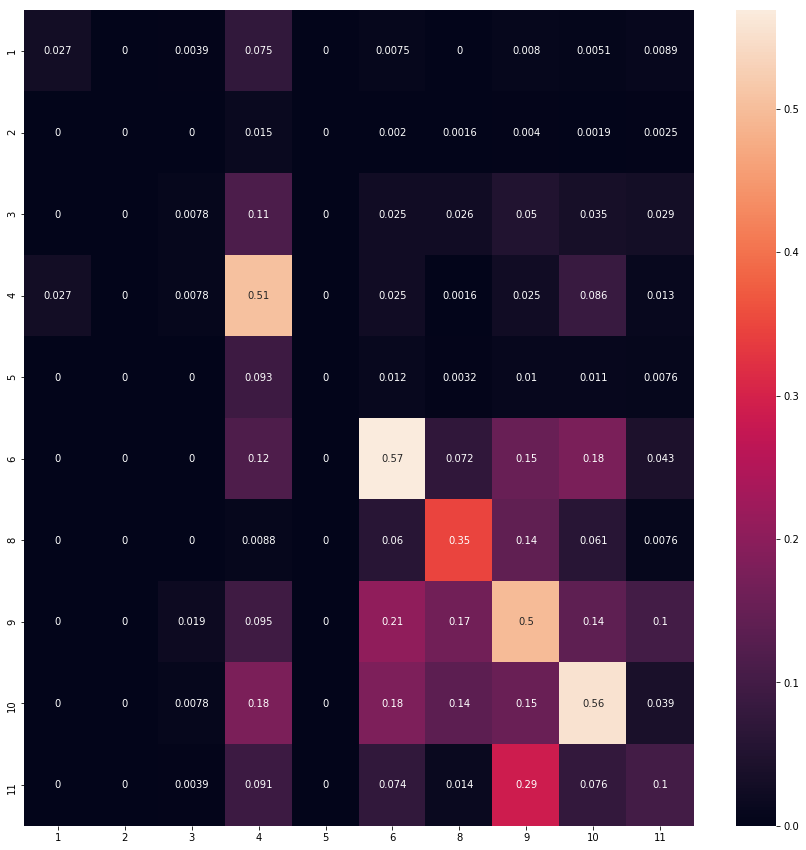

In [80]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

## Выводы:
Значение alpha получение через GridSearch с кросс-валидацией дает результаты по точности и ошибке на тесте хуже, чем дефолтное alpha

## Пробуем на оптимальном alpha, но с большим количеством нейронов
500 нейронов

In [129]:
mlp_model = MLPClassifier(hidden_layer_sizes = (500,), solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [130]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [131]:
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.6450482033304119
test error: 0.6505988898626935


In [132]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.3549517966695881
test accuracy:  0.34940111013730646


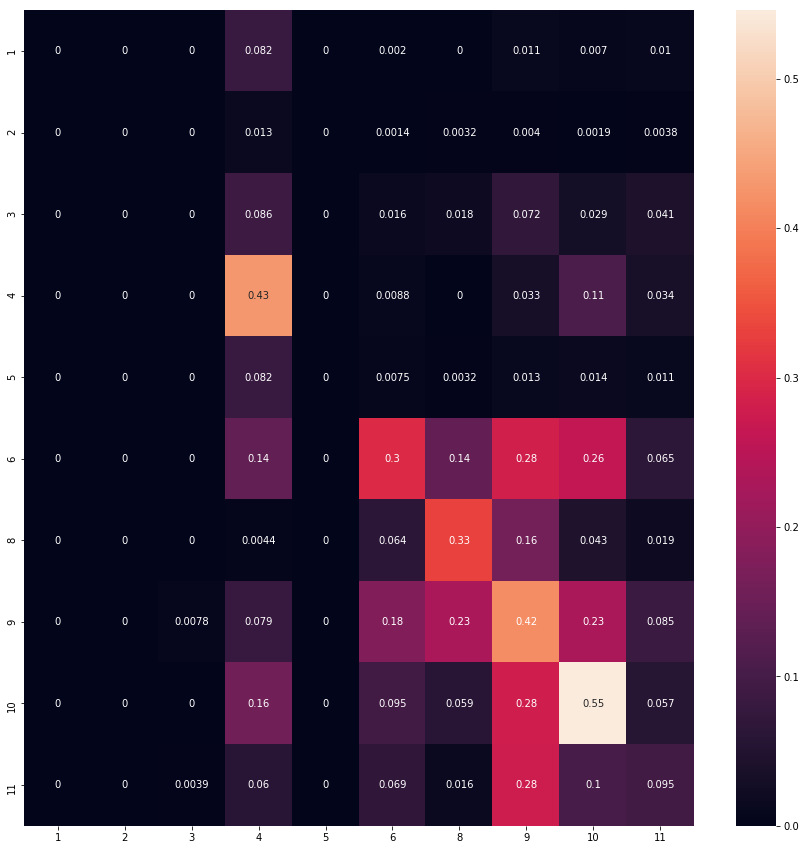

In [133]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

## Выводы:
Ошибки на тренировочном и тестовом выборках ухудшились. Можно предположить, что из-за большого количества нейронов происходит затухание градиентов. Если несоразмерно увеличивать в ширину и в глубину сетку, то такая проблема может возникнуть. 
Попробуем использовать функцию активации RELU вместо сигмоиды, так как RELU менее подверженна к проблеме затухания градиентов

RELU activation function

In [125]:
mlp_model = MLPClassifier(hidden_layer_sizes = (500,), solver = 'lbfgs', activation = 'relu', random_state = 42)
mlp_model.fit(X_train, y_train)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [126]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [127]:
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.43013647176662073
test error: 0.4664037394098744


In [128]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.5698635282333793
test accuracy:  0.5335962605901257


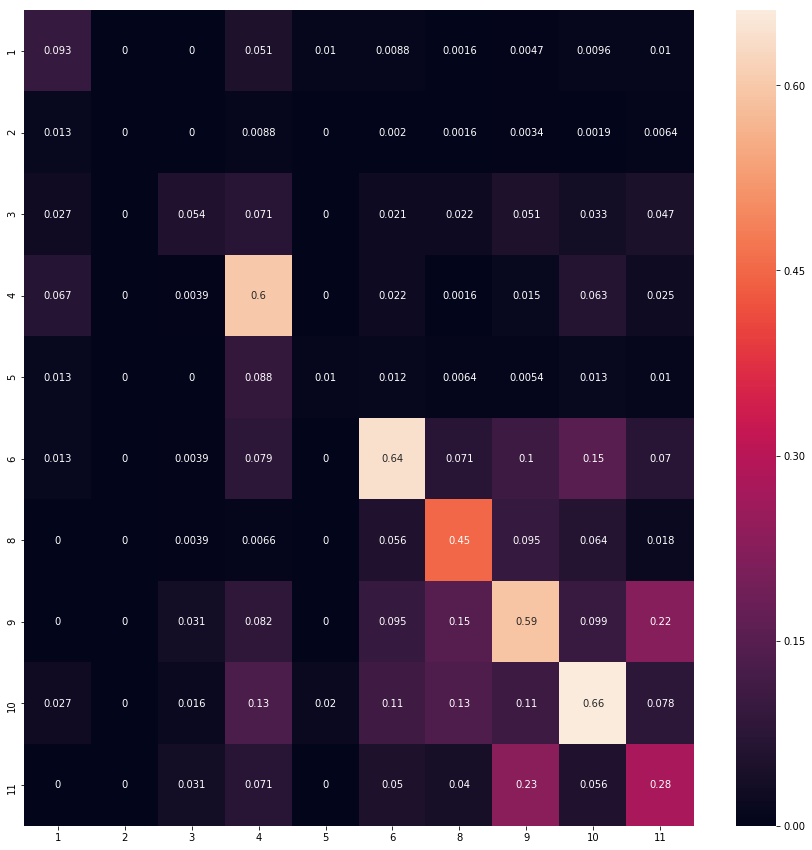

In [124]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

## Выводы:
Как и ожидалось, что функция активации relu решает проблему затухания градиента. Однако, если мы желаем выявить оптимальное количество нейронов для одного слоя, то можно запустить кросс-валидацию

In [145]:
num_neuron_arr = [(10,),(20,),(30,),(50,),(80,),(100,),(120,),(130,),(150,),(180,),(200,),(210,),(220,),(230,),(250,),(280,),(300,)]
mlp_model = MLPClassifier(solver = 'lbfgs', activation = 'logistic', random_state = 42)
grid = GridSearchCV(mlp_model, param_grid={'hidden_layer_sizes': num_neuron_arr}, cv=3)
grid.fit(X_train, y_train)
best_cv_err = 1 - grid.best_score_
#best_alpha = grid.best_estimator_.alpha

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):

In [147]:
best_num_neuron = grid.best_estimator_.hidden_layer_sizes
print(best_num_neuron)

(30,)


### Пробуем на количестве нейроном 30 с одним слоем

In [152]:
mlp_model = MLPClassifier(hidden_layer_sizes = best_num_neuron, solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [153]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [154]:
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.5207211719043445
test error: 0.5276073619631901


In [155]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.4792788280956554
test accuracy:  0.4723926380368098


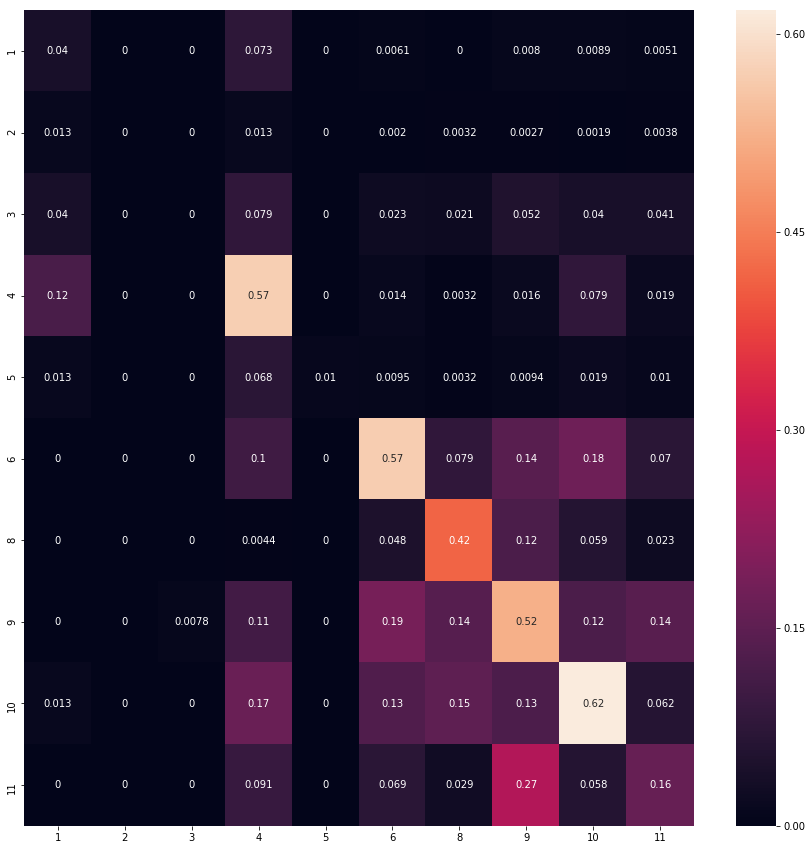

In [156]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

### Вывод:
Так и получается, что если функция активации сигмоида, то лучший результат по ошибке и точности на тренировочном и тестовом наборе данных получается при количество нейронов = 30 

### Пробуем 2 полносвязанных скрытых слоя на оптимальном alpha = 0.0001 и на оптимальном количестве нейронов для 1 слоя с сигмоидальной функцией активации
Пробуем сигмоиду

In [170]:
mlp_model = MLPClassifier(hidden_layer_sizes = (30,30), solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [171]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [172]:
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.5004382120946538
test error: 0.5058428279287175


In [173]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.49956178790534617
test accuracy:  0.4941571720712825


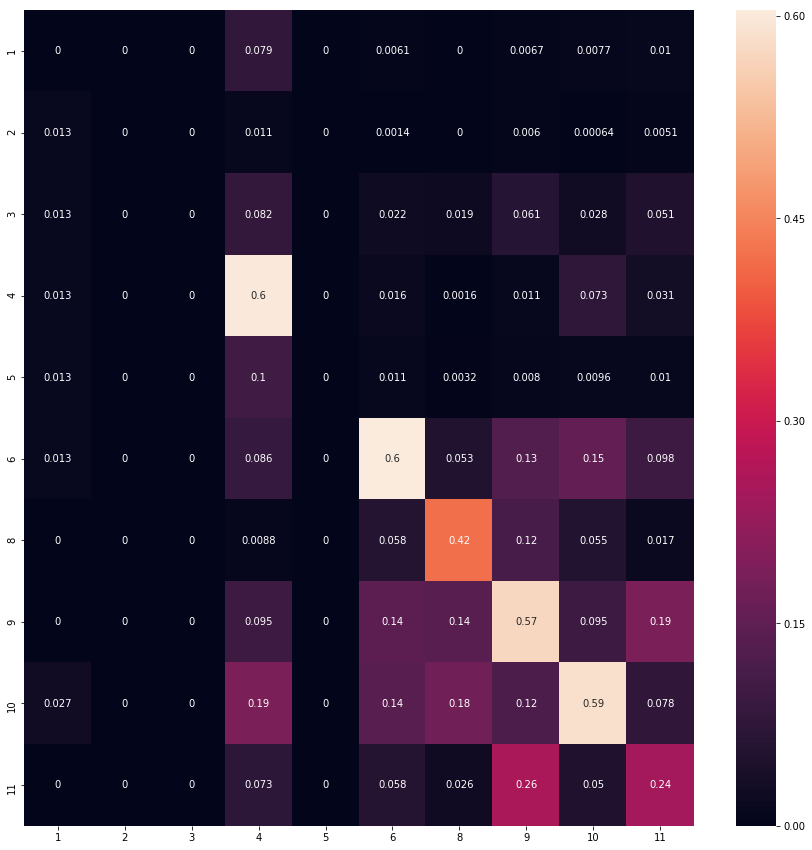

In [174]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

## Выводы:
Исходя из train и test error/accuracy очевидно использование двух полносвязанных слоев дает лучшие результаты, чем одного слоя. Можно было бы запустить также кросс-валидации для выявления оптимального количества нейронов для двух слоей, но не станем. Так как уже очевидно, что использовать два слоя лучше, чем один

### Меняем solver на sgd/adam
Так как сетка маленькая, не потребуется много времени на обучение и инференс модели.
Также обучем только на самом оптимальном alpha, то есть дефолтном alpha = 0.0001

In [178]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'sgd', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [179]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.6746588205834481
test error: 0.6836108676599474


In [180]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.3253411794165519
test accuracy:  0.31638913234005256


SGD выдает результаты хуже в сравнении с lbfgs для 100 нейронов(дефолтное значение) при одном слое. Все же проверим и для adam

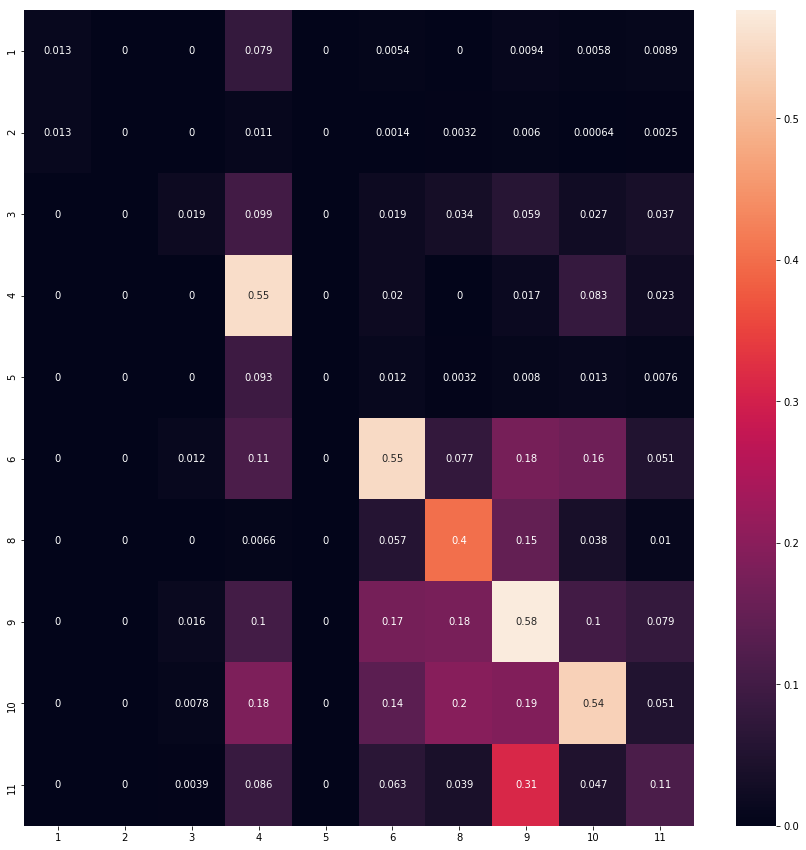

In [184]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

In [181]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'adam', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

/home/topus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [182]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print("train error:",np.mean(y_train != y_train_pred))
print("test error:",np.mean(y_test != y_test_pred))

train error: 0.5379992487792663
test error: 0.5461583406368682


In [183]:
print("train accuracy: ", mlp_model.score(X_train, y_train))
print("test accuracy: ", mlp_model.score(X_test, y_test))

train accuracy:  0.4620007512207337
test accuracy:  0.45384165936313176


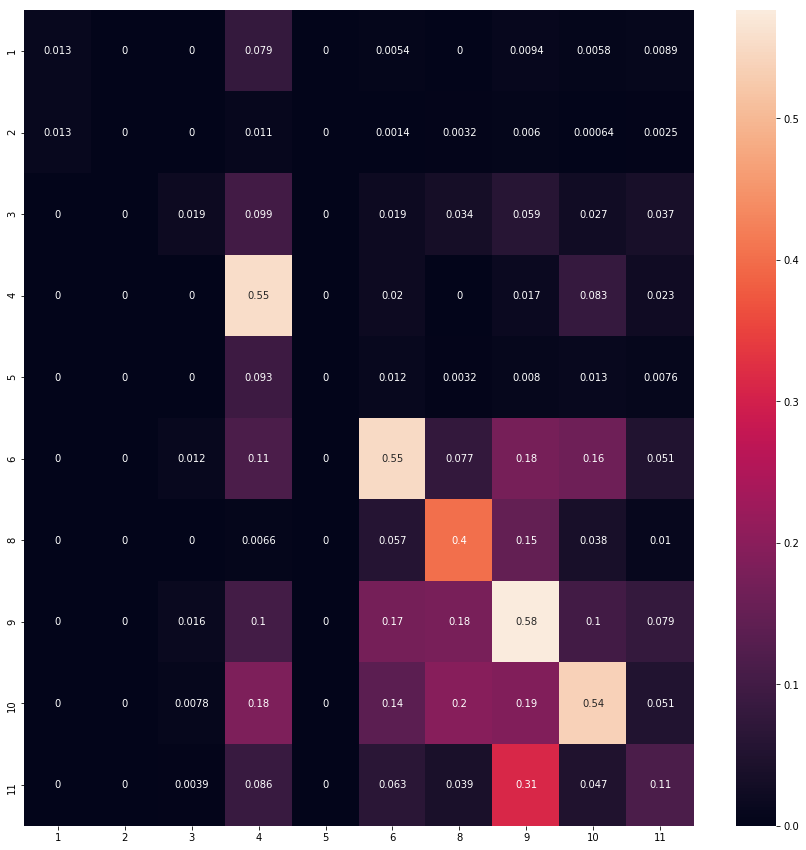

In [185]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred,labels=labels_)
# normalized cofusion matrix
plt.figure(figsize=(15,15))
ax = sns.heatmap(cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1), annot=True,xticklabels=labels_,yticklabels=labels_)

Adam выдает самые лучшие результаты в сравнении с прошлыми двумя солверами

# Conclusion
1) Для нашей задачи лучшим alpha оказалось дефолтное значение alpha = 0.0001
2) Функция активации ReLU чаще лучше, чем logistic, так как ReLU меньше подверженна затуханию градиента и разряженные представления, потому что нет отрицательных значений
3) В сравнении солверов для данной задачи лучше работает Adam

Остальные выводы были предоставлены во время работы, а не в конце